<a href="https://colab.research.google.com/github/alam740/Data-Analytics-Course/blob/master/ECE_595_Lecture13_Physics_based_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Physics-based Machine Learning

*This notebook accompanies the ECE595 Data analytics course taught at Purdue in Fall 2022. These set of examples pertain to the materials of lecture 13.*

*Written by Jabir Bin Jahangir (jabir@purdue.edu)*

---




# Example 1: Using physics informed neural networks (PINNs) to solve nonlinear ODEs

## Velocity of a falling body with air resistance 

The velocity of skydiver falling from plane in the presence of air resistance can be modeled with the following nonlinear ODE
$$ 
  u' = g - bu^2 \\ 
  u(t = 0) = 0
$$

where, $u(t)$ is velocity as a function of time, $g$ is acceleration due to gravity and $b$ is a parameter that depends on mass of the object and drag coefficient. 

In the following example we use a physics inspired neural network to solve the nonlinear ODE. This implementation is largely based on the parabolic PDE solver by https://github.com/maziarraissi/PINNs


### 1. Import necessary packages and set problem specific data


In [ ]:
# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np

# Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)

# Define the model parameters 
b = 1; 
g = 9.8; 

# Define initial condition
def fun_u_0(x):
    return 0;


The residual is defined as the functional 
$$
  r_\theta (t) := u_\theta' - g + bu_\theta^2 .
$$
where, $u_\theta(t)$ is the solution approximated by neural network. A correct solution $ u_\theta(t) = u(t) $ would lead to $r(t) = 0$ at all collocation points.

In [ ]:
# Define residual of the ODE
def fun_r(t, u, u_t):
    return u_t + (b * u**2) - g

### 2. Generate a set of collocation points



In [ ]:
# Set number of data points
N_0 = 1       # initial conditions
N_r = 1000    # collocation points 

# Set boundary
tmin = 0.
tmax = 1.

# Set random seed for reproducible results
tf.random.set_seed(0)

# Evaluate intitial condition at t_0
# u(t=0) = 0 for this problem
u_0 = tf.zeros((1,1), dtype=DTYPE);

# Draw uniformly sampled collocation points
t_r = tf.random.uniform((N_r,1), tmin, tmax, dtype=DTYPE)

# Store collocation points. 
X_r = tf.concat([t_r], axis=1)

# initial data
u_data = [u_0]


### 3. Set up network architecture



In [ ]:
# Model initializer
def init_model(num_hidden_layers= 8, num_neurons_per_layer=20):
    # Initialize a feedforward neural network
    model = tf.keras.Sequential()

    # Input is one dimesional, time
    model.add(tf.keras.Input(1))

    # Introduce a scaling layer to map input to [lb, ub]
    scaling_layer = tf.keras.layers.Lambda(
                lambda x: 2.0*(x)/(1) - 1.0)
    model.add(scaling_layer)

    # Append hidden layers
    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get('tanh'),
            kernel_initializer='glorot_normal'))

    # Output is one-dimensional. velocity
    model.add(tf.keras.layers.Dense(1))
    
    return model

### Get the residuals



In the following code cell, we define a function which evaluates the residual

$$
\begin{align}
    r_\theta (t) := u_\theta' - g + bu_\theta^2 .
\end{align}
$$

of the nonlinear ODE in the points $X_r = \{t^r_i\}_{i=1}^{N_r}$.
To compute the necessary partial derivatives we use the automatic differentiation capabilities of TensorFlow.

For this problem, this entails computing $ u_\theta'(t) $.
In TensorFlow, this is done via a `GradientTape`, see also the [documentation](https://www.tensorflow.org/api_docs/python/tf/GradientTape), which keeps track of the `watched` variables, in our case `t` and `x`, in order to compute the derivatives.

In [ ]:
def get_r(model, X_r):
    
    # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape:
        # Split t and x to compute partial derivatives
        t = X_r[:, 0:1]

        # Variables t is watched  during tape
        # to compute derivatives u_t
        tape.watch(t)

        # Determine residual 
        u = model(tf.stack(t[:,0], axis=0))

    u_t = tape.gradient(u, t)

    del tape
    return fun_r(t, u, u_t)

The next function computes the loss for our model. There will two loss terms that will have to be minimized: (1) $ \phi_\theta^r $ associated with the residuals at the collocation points (2) $\phi_\theta^0$ associated with the initial condition. Thus, the total loss is defined

$$
\begin{align}
    \phi_\theta(X) := \phi_\theta^r(X^r) + \phi_\theta^0(u_0) 
\end{align}
$$

as a function of our the training data.
The collocation points are given by `X_r`, the initial data is contained in  `u_data = [u_0]`.

In [ ]:
def compute_loss(model, X_r, u_data):
    
    # Compute phi^r = collocation points loss
    r = get_r(model, X_r)
    phi_r = tf.reduce_mean(tf.square(r)) 
    
    # Initialize loss
    loss = phi_r
    
    # Add loss for initial condition
    for i in range(len(u_data)):
        u_pred = model(u_data)
        loss += tf.reduce_mean(tf.square(u_pred))
    return loss

The next function computes the gradient of the loss function $\phi_\theta$ with respect to the unknown variables in the model, also called `trainable_variables` in TensorFlow, i.e. $\nabla_\theta \phi_\theta$.
This is also done via a `GradientTape`, but now it keeps track of the parameters $\theta$ in our model, which can be accessed by `model.trainable_variables`.

In [ ]:
def get_grad(model, X_r, u_data):
    
    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        tape.watch(model.trainable_variables)
        loss = compute_loss(model, X_r, u_data)

    g = tape.gradient(loss, model.trainable_variables)
    del tape
    return loss, g

### Set up optimizer and train model

Next we initialize the model, set the learning rate to the step function

$$
\delta(n) = 0.01 \, \textbf{1}_{\{n < 1000\}} + 0.001 \, \textbf{1}_{\{1000 \le n < 3000\}} + 0.0005 \, \textbf{1}_{\{3000 \le n\}}
$$

which decays in a piecewise constant fashion, and set up a `tf.keras.optimizer` to train the model.

In [ ]:
# Initialize a model with 2 hidden layers each with 2 neurons
model = init_model(2, 2)

# We choose a piecewise decay of the learning rate, i.e., the
# step size in the gradient descent type algorithm
# the first 1000 steps use a learning rate of 0.01
# from 1000 - 3000: learning rate = 0.001
# from 3000 onwards: learning rate = 0.0005

lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])

# Choose the optimizer
optim = tf.keras.optimizers.Adam(learning_rate=lr)

Train the model for $N=5000$ epochs.
Here, we set up a function `train_step()` which performs one training step.

*Note*: The `@tf.function` is a so-called `Decorator` within Python. This particular decorator redefines the function that follows, in our case `train_step`, as a TensorFlow graph which may speed up the training significantly.

In [ ]:
from time import time

# Define one training step as a TensorFlow function to increase speed of training
@tf.function
def train_step():
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = get_grad(model, X_r, u_data)
    
    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))
    
    return loss

# Number of training epochs
N = 5000
hist = []

# Start timer
t0 = time()

for i in range(N+1):
    
    loss = train_step()
    
    # Append current loss to hist
    hist.append(loss.numpy())
    
    # Output current loss after 50 iterates
    if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))
        
# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: loss = 1.68080658e+02
It 00050: loss = 4.26436729e+01
It 00100: loss = 7.16359615e-01
It 00150: loss = 3.14694762e-01
It 00200: loss = 1.97669119e-01
It 00250: loss = 1.39152259e-01
It 00300: loss = 9.80320573e-02
It 00350: loss = 6.77353740e-02
It 00400: loss = 4.67942283e-02
It 00450: loss = 3.31332535e-02
It 00500: loss = 2.45775748e-02
It 00550: loss = 1.93729270e-02
It 00600: loss = 1.62565317e-02
It 00650: loss = 1.43832751e-02
It 00700: loss = 1.32204667e-02
It 00750: loss = 1.24490848e-02
It 00800: loss = 1.18869524e-02
It 00850: loss = 1.14342906e-02
It 00900: loss = 1.10390438e-02
It 00950: loss = 1.06750382e-02
It 01000: loss = 1.03298463e-02
It 01050: loss = 1.02896066e-02
It 01100: loss = 1.02544539e-02
It 01150: loss = 1.02183083e-02
It 01200: loss = 1.01810573e-02
It 01250: loss = 1.01427808e-02
It 01300: loss = 1.01034949e-02
It 01350: loss = 1.00631537e-02
It 01400: loss = 1.00218216e-02
It 01450: loss = 9.97945387e-03
It 01500: loss = 9.93606448e-03
It 01550

### Plot solution and losses

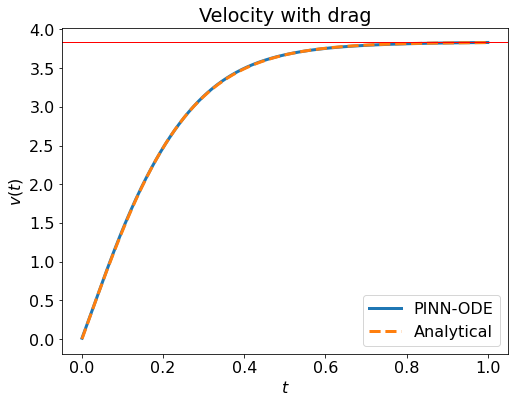

In [ ]:
import math 

N = 600
tspace = np.linspace(tmin, tmax, N + 1)

# Determine predictions of u(t)
upred = model(tspace)

# Analytical solution for u(t)
u_a = math.sqrt(g/b)* np.tanh(np.multiply(tspace, math.sqrt(g*b)));

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16})

# Plot of solution u(t)
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()
ax.plot(tspace, upred, linewidth=3, label='PINN-ODE')
ax.plot(tspace, u_a, linestyle='dashed', linewidth=3,  label='Analytical')
ax.set_xlabel('$t$')
ax.set_ylabel('$v(t)$')
ax.legend()
plt.axhline(y = math.sqrt(g/b), linewidth=1, color='r')
ax.set_title('Velocity with drag');
# #plt.savefig('Burgers_Solution.pdf', bbox_inches='tight', dpi=300);

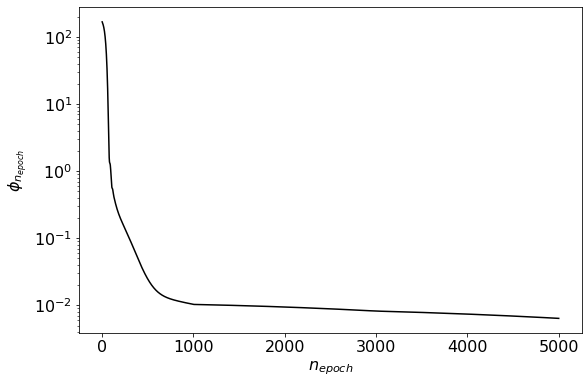

In [ ]:
# Plot the loss function
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(hist)), hist,'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('$\\phi_{n_{epoch}}$');

# Example 2: Solving PDEs with PINN 

In this second example, we solve the Burger's equation. 

We consider the one-dimensional Burgers equation on the spatial domain $\mathcal{D} = [-1,1]$

$$
\begin{aligned}
    \partial_t u + u \, \partial_x u - (0.01/\pi) \, \partial_{xx} u &= 0, \quad &&\quad (t,x) \in (0,1] \times (-1,1),\\
   u(0,x) &= - \sin(\pi \, x),                 \quad &&\quad x \in [-1,1],\\
   u(t,-1) = u(t,1) &= 0,                      \quad &&\quad t \in (0,1].
\end{aligned}
$$

> This PDE arises in various disciplines such as traffic flow, fluid mechanics and gas dynamics, and can be derived from the Navier-Stokes equations, see 
([Basdevant et al., 1986](https://www.researchgate.net/publication/222935980_Spectral_and_finite_difference_solutions_of_Burgers_equation)).

Note that, we now want to solve for the field $u(t,x)$. 

In [ ]:
# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np

# Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)

# Set constants
pi = tf.constant(np.pi, dtype=DTYPE)
viscosity = .01/pi

# Define initial condition
def fun_u_0(x):
    return -tf.sin(pi * x)

# Define boundary condition
def fun_u_b(t, x):
    n = x.shape[0]
    return tf.zeros((n,1), dtype=DTYPE)



The residual is defined as 
$$
\begin{align}
    r_\theta (t,x) := \partial_t u_\theta + u_\theta \, \partial_x u_\theta - (0.01/\pi) \, \partial_{xx} u_\theta.
\end{align}
$$

In [ ]:
# Define residual of the PDE
def fun_r(t, x, u, u_t, u_x, u_xx):
    return u_t + u * u_x - viscosity * u_xx

### 2. Generate a set of collocation points



In [ ]:
# Set number of data points
N_0 = 50
N_b = 50
N_r = 10000

# Set boundary
tmin = 0.
tmax = 1.
xmin = -1.
xmax = 1.

# Lower bounds
lb = tf.constant([tmin, xmin], dtype=DTYPE)
# Upper bounds
ub = tf.constant([tmax, xmax], dtype=DTYPE)

# Set random seed for reproducible results
tf.random.set_seed(0)

# Draw uniform sample points for initial boundary data
t_0 = tf.ones((N_0,1), dtype=DTYPE)*lb[0]
x_0 = tf.random.uniform((N_0,1), lb[1], ub[1], dtype=DTYPE)
X_0 = tf.concat([t_0, x_0], axis=1)

# Evaluate intitial condition at x_0
u_0 = fun_u_0(x_0)

# Boundary data
t_b = tf.random.uniform((N_b,1), lb[0], ub[0], dtype=DTYPE)
x_b = lb[1] + (ub[1] - lb[1]) * tf.keras.backend.random_bernoulli((N_b,1), 0.5, dtype=DTYPE)
X_b = tf.concat([t_b, x_b], axis=1)

# Evaluate boundary condition at (t_b,x_b)
u_b = fun_u_b(t_b, x_b)

# Draw uniformly sampled collocation points
t_r = tf.random.uniform((N_r,1), lb[0], ub[0], dtype=DTYPE)
x_r = tf.random.uniform((N_r,1), lb[1], ub[1], dtype=DTYPE)
X_r = tf.concat([t_r, x_r], axis=1)

# Collect boundary and inital data in lists
X_data = [X_0, X_b]
u_data = [u_0, u_b]

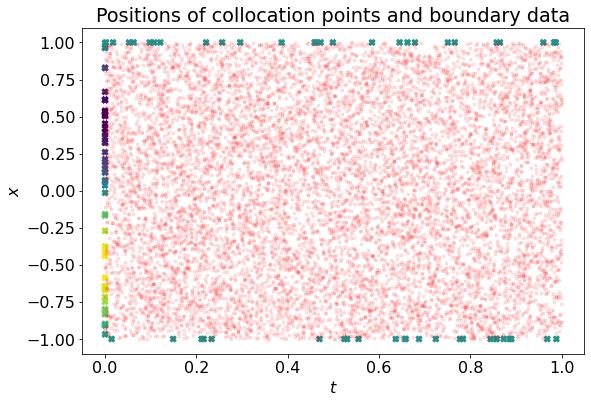

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9,6))
plt.scatter(t_0, x_0, c=u_0, marker='X', vmin=-1, vmax=1)
plt.scatter(t_b, x_b, c=u_b, marker='X', vmin=-1, vmax=1)
plt.scatter(t_r, x_r, c='r', marker='.', alpha=0.1)
plt.xlabel('$t$')
plt.ylabel('$x$')

plt.title('Positions of collocation points and boundary data');
#plt.savefig('Xdata_Burgers.pdf', bbox_inches='tight', dpi=300)

### 3. Set up network architecture



In [ ]:
def init_model(num_hidden_layers=8, num_neurons_per_layer=20):
    # Initialize a feedforward neural network
    model = tf.keras.Sequential()

    # Input is two-dimensional (time + one spatial dimension)
    model.add(tf.keras.Input(2))

    # Introduce a scaling layer to map input to [lb, ub]
    scaling_layer = tf.keras.layers.Lambda(
                lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)
    model.add(scaling_layer)

    # Append hidden layers
    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get('tanh'),
            kernel_initializer='glorot_normal'))

    # Output is one-dimensional
    model.add(tf.keras.layers.Dense(1))
    
    return model

### Get the residuals

### 4. Define routines to determine loss and gradient

In the following code cell, we define a function which evaluates the residual

$$
\begin{align}
   r_\theta (t,x) := \partial_t u_\theta + u_\theta \, \partial_x u_\theta - (0.01/\pi) \, \partial_{xx} u_\theta.
\end{align}
$$

of the nonlinear PDE in the points $X_r = \{(t^r_i,x^r_i)\}_{i=1}^{N_r}$.
To compute the necessary partial derivatives we use the automatic differentiation capabilities of TensorFlow.

For the Burgers equation, this entails computing $\partial_t u_\theta$, $\partial_x u_\theta$ and $\partial_{xx} u_\theta$.
In TensorFlow, this is done via a `GradientTape`, see also the [documentation](https://www.tensorflow.org/api_docs/python/tf/GradientTape), which keeps track of the `watched` variables, in our case `t` and `x`, in order to compute the derivatives.

In [ ]:
def get_r(model, X_r):
    
    # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape:
        # Split t and x to compute partial derivatives
        t, x = X_r[:, 0:1], X_r[:,1:2]

        # Variables t and x are watched during tape
        # to compute derivatives u_t and u_x
        tape.watch(t)
        tape.watch(x)

        # Determine residual 
        u = model(tf.stack([t[:,0], x[:,0]], axis=1))

        # Compute gradient u_x within the GradientTape
        # since we need second derivatives
        u_x = tape.gradient(u, x)
            
    u_t = tape.gradient(u, t)
    u_xx = tape.gradient(u_x, x)

    del tape

    return fun_r(t, x, u, u_t, u_x, u_xx)

The next function computes the loss for our model

$$
\begin{align}
    \phi_\theta(X) := \phi_\theta^r(X^r) + \phi_\theta^0(X^0) + \phi_\theta^b(X^b),
\end{align}
$$

as a function of our the training data.
The collocation points are given by `X_r`, the initial and boundary data is contained in `X_data = [X_0, X_b]` and `u_data = [u_0, u_b]`.

In [ ]:
def compute_loss(model, X_r, X_data, u_data):
    
    # Compute phi^r
    r = get_r(model, X_r)
    phi_r = tf.reduce_mean(tf.square(r))
    
    # Initialize loss
    loss = phi_r
    
    # Add phi^0 and phi^b to the loss
    for i in range(len(X_data)):
        u_pred = model(X_data[i])
        loss += tf.reduce_mean(tf.square(u_data[i] - u_pred))
    
    return loss

In [ ]:
def get_grad(model, X_r, X_data, u_data):
    
    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        tape.watch(model.trainable_variables)
        loss = compute_loss(model, X_r, X_data, u_data)

    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, g

### Set up optimizer and train model

In [ ]:
# Initialize model aka u_\theta
model = init_model()

# We choose a piecewise decay of the learning rate, i.e., the
# step size in the gradient descent type algorithm
# the first 1000 steps use a learning rate of 0.01
# from 1000 - 3000: learning rate = 0.001
# from 3000 onwards: learning rate = 0.0005

lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])

# Choose the optimizer
optim = tf.keras.optimizers.Adam(learning_rate=lr)

In [ ]:
from time import time

# Define one training step as a TensorFlow function to increase speed of training
@tf.function
def train_step():
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = get_grad(model, X_r, X_data, u_data)
    
    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))
    
    return loss

# Number of training epochs
N = 5000
hist = []

# Start timer
t0 = time()

for i in range(N+1):
    
    loss = train_step()
    
    # Append current loss to hist
    hist.append(loss.numpy())
    
    # Output current loss after 50 iterates
    if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))
        
# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: loss = 7.10192621e-01
It 00050: loss = 2.37236708e-01
It 00100: loss = 1.41465098e-01
It 00150: loss = 1.06792204e-01
It 00200: loss = 8.92100856e-02
It 00250: loss = 8.31827670e-02
It 00300: loss = 7.42608756e-02
It 00350: loss = 9.47560146e-02
It 00400: loss = 5.90070263e-02
It 00450: loss = 1.51917920e-01
It 00500: loss = 7.09418431e-02
It 00550: loss = 5.83499931e-02
It 00600: loss = 8.40041712e-02
It 00650: loss = 2.81093661e-02
It 00700: loss = 3.41406427e-02
It 00750: loss = 4.44361754e-02
It 00800: loss = 8.69973004e-02
It 00850: loss = 3.40919420e-02
It 00900: loss = 3.46570946e-02
It 00950: loss = 1.03517622e-02
It 01000: loss = 1.84044782e-02
It 01050: loss = 2.56154803e-03
It 01100: loss = 2.44578510e-03
It 01150: loss = 2.34917575e-03
It 01200: loss = 2.26008613e-03
It 01250: loss = 2.17623147e-03
It 01300: loss = 2.09666369e-03
It 01350: loss = 2.02087103e-03
It 01400: loss = 1.94853614e-03
It 01450: loss = 1.87943887e-03
It 01500: loss = 1.81341986e-03
It 01550

### Plot solution and losses

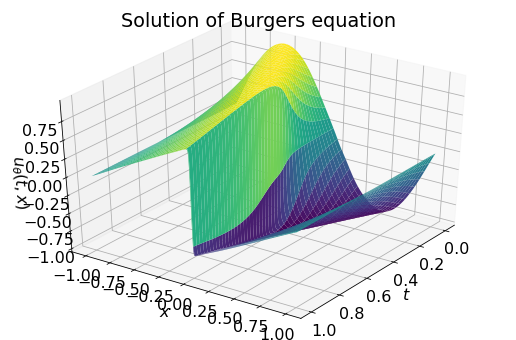

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Set up meshgrid
N = 600
tspace = np.linspace(lb[0], ub[0], N + 1)
xspace = np.linspace(lb[1], ub[1], N + 1)
T, X = np.meshgrid(tspace, xspace)
Xgrid = np.vstack([T.flatten(),X.flatten()]).T

# Determine predictions of u(t, x)
upred = model(tf.cast(Xgrid,DTYPE))

# Reshape upred
U = upred.numpy().reshape(N+1,N+1)

# Surface plot of solution u(t,x)
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(T, X, U, cmap='viridis');
ax.view_init(35,35)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_zlabel('$u_\\theta(t,x)$')
ax.set_title('Solution of Burgers equation');

#plt.savefig('Burgers_Solution.pdf', bbox_inches='tight', dpi=300);

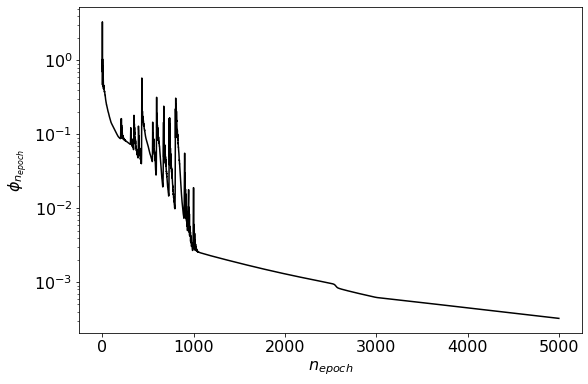

In [ ]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(hist)), hist,'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('$\\phi_{n_{epoch}}$');

# Example 3: Learning the exponent matrix from data with neural networks

In the following example BuckiNet, a neural network with dimensional homogenity constraint, is used to discover the exponent matrix from data. The network finds the set of $\pi$ parameters to best represent the input-output relationship in data.

*Why would you want do this since the $\pi$-theorem already provide a systematic apporach for deriving the dimensionless groups as shown before?*- By imposing the Buckinham $\pi$ -theorem as a constraint, a subset of the trained neural network parameters now have a physical interpretation. This can inform data-driven discovery of dimensionless variables governing a process. Also the dimensional reduction helps regularize overfitting.


This example is from *Bakarji, J., Callaham, J., Brunton, S. L., & Kutz, J. N. (2022). Dimensionally consistent learning with buckingham pi. arXiv preprint arXiv:2202.04643.*




## Load BuckiNet

In [ ]:
!rm -R ./BuckiNet 
!git clone --branch analysis-tools https://github.com/josephbakarji/bucki-data.git BuckiNet

rm: cannot remove './BuckiNet': No such file or directory
Cloning into 'BuckiNet'...
remote: Enumerating objects: 124, done.
remote: Counting objects: 100% (124/124), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 124 (delta 42), reused 116 (delta 34), pack-reused 0
Receiving objects: 100% (124/124), 2.57 MiB | 8.84 MiB/s, done.
Resolving deltas: 100% (42/42), done.


## Damped bead on a rotating Hoop


*Example code from: https://github.com/josephbakarji/bucki-data*




> From Sec. 3.5 in Strogatz.  Full equation:
  $$
  m R \ddot{\phi} = -b \dot{\phi} - m g \sin \phi + m R^2 \omega \sin \phi \cos \phi
  $$

 > If we introduce nondimensionalizations
  $$
  \gamma = \frac{R \omega^2}{g} \hspace{2cm} \epsilon = \frac{m^2 g R}{b^2}  \hspace{2cm} \tau = \frac{t}{T} = \frac{b}{mg},
  $$
  the equation becomes
  $$
  \epsilon \frac{d^2 \phi}{d \tau^2} = - \frac{d \phi}{d \tau} - \sin \phi + \gamma \sin \phi \cos \phi.
  $$
  For $\epsilon \ll 1$ and $\gamma = \mathcal{O}(1)$, the system is overdamped and approximately first-order.  The system undergoes a pitchfork bifurcation at $\gamma = 1$.

In [ ]:
# Matplotlib

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams
mpl.rc('text', usetex=True)
mpl.rc('font', family='serif')
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)
mpl.rc('axes', labelsize=20)
mpl.rc('axes', titlesize=20)
mpl.rc('figure', figsize=(6, 4))
%config InlineBackend.figure_format = 'retina'

from numpy.linalg import matrix_rank
import sys
sys.path.append('./BuckiNet/src')
sys.path.append('./BuckiNet/solvers')

from rotating_hoop import RotatingHoop
from learning import KRidgeReg, NeuralNet, BuckyNet
from nullspace_search import get_nondim_numbers, fit_allnondim
from helper_functions import prettify_results

nsamples = int(6e3)
output_type = 'svd' # options: 'dynamic', 'static', 'svd' - 
num_nondim = 3 # !! Recomputed below - num_nondim=3 also works for 'svd' in some cases !!
num_modes = 5
tsteps = 100 # For 'dynamic', use smaller number of tsteps - dynamic still takes too long
tend = 2
phi_init = [1, 0]

## Get solution
R = RotatingHoop(nsamples=nsamples, output_type=output_type, modes=num_modes, time_steps=tsteps, tend=tend, phi0=phi_init)
inputs, outputs = R.get_data()
dim_matrix = R.get_dim_matrix()


In [ ]:
inputs.shape

(6000, 5)

In [ ]:
verbose = 1
num_layers = 3
num_neurons = 80
activation = 'elu'
initializer = 'he_normal'
nepoch = 10000 *5
patience = 100
test_size = 0.2
nullspace_loss = .8 # Set to weight \in [0, 1] if want to turn on
l1_reg = 0.000
l2_reg = 0.000
adamlr = 0.002

B = BuckyNet(inputs, outputs, dim_matrix, num_nondim=num_nondim, num_layers=num_layers, num_neurons=num_neurons, activation=activation, verbose=verbose, initializer=initializer, nepoch=nepoch, 
             patience=patience, test_size=test_size, nullspace_loss=nullspace_loss, l1_reg=l1_reg, l2_reg=l2_reg, adamlr=adamlr)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
x = B.single_run() # This make take some time to finish

Epoch 1/50000
120/120 [==============================] - 1s 4ms/step - loss: 24.7680 - root_mean_squared_error: 4.6085 - val_loss: 3.5245 - val_root_mean_squared_error: 0.1783
Epoch 2/50000
120/120 [==============================] - 0s 2ms/step - loss: 3.4971 - root_mean_squared_error: 0.1479 - val_loss: 3.4696 - val_root_mean_squared_error: 0.1194
Epoch 3/50000
120/120 [==============================] - 0s 2ms/step - loss: 3.4567 - root_mean_squared_error: 0.1585 - val_loss: 3.4110 - val_root_mean_squared_error: 0.0721
Epoch 4/50000
120/120 [==============================] - 0s 2ms/step - loss: 3.3860 - root_mean_squared_error: 0.0940 - val_loss: 3.3576 - val_root_mean_squared_error: 0.1050
Epoch 5/50000
120/120 [==============================] - 0s 2ms/step - loss: 3.3184 - root_mean_squared_error: 0.0678 - val_loss: 3.2826 - val_root_mean_squared_error: 0.0621
Epoch 6/50000
120/120 [==============================] - 0s 2ms/step - loss: 3.2466 - root_mean_squared_error: 0.0675 - val_

In [ ]:

idxs = [1, 1, -1]

x1_norm = x[:, 0]/x[idxs[0], 0]
x2_norm = x[:, 1]/x[idxs[1], 1]
x3_norm = x[:, 2]/x[idxs[2], 2]
Pi, names = R.get_dim_matrix(include_names=True)

print(x)
print('-------------')
print(x1_norm)
print(x2_norm)
print(x3_norm)
print('-------------')
print(x@Pi)



[[-0.06145957  0.40295848 -0.20627718]
 [ 0.2684898   0.24351527  0.1100591 ]
 [ 0.06169666 -0.4036436   0.2052996 ]
 [-0.329207    0.15996833 -0.3164217 ]
 [ 0.5977145   0.08358763  0.42572576]]
-------------
[-0.2289084   1.          0.22979145 -1.2261434   2.2262092 ]
[ 1.6547565   1.         -1.65757     0.6569129   0.34325418]
[-0.48453066  0.25852114  0.4822344  -0.7432524   1.        ]
-------------
[[ 0.40295848 -0.06145957  0.54777608  0.35109478  0.20627718]
 [ 0.24351527  0.26848981  0.40194597  0.0483716  -0.1100591 ]
 [-0.40364361  0.06169666 -0.54724655 -0.34890254 -0.2052996 ]
 [ 0.15996833 -0.329207    0.14718302  0.30363637  0.31642169]
 [ 0.08358763  0.59771448  0.25557636 -0.25373703 -0.42572576]]


In [ ]:
from helper_functions import prettify_results

print('\n-------')
prettify_results(x1_norm, names, tol=0.1, max_degree=6)
print('\n-------')
prettify_results(x2_norm, names, tol=0.1, max_degree=6)
print('\n-------')
prettify_results(x3_norm, names, tol=0.1, max_degree=6)

## Known result is not guaranteed, but loss seems to be a good indicator


-------
[-0.2289084   1.          0.22979145 -1.2261434   2.2262092 ]
m : -0.25
R : 1
b : 0.25
g : -1.25
w : 2.25


<IPython.core.display.Math object>


-------
[ 1.6547565   1.         -1.65757     0.6569129   0.34325418]
m : 1.6666666666666665
R : 1
b : -1.6666666666666665
g : 0.6666666666666666
w : 0.3333333333333333


<IPython.core.display.Math object>


-------
[-0.48453066  0.25852114  0.4822344  -0.7432524   1.        ]
m : -0.5
R : 0.3333333333333333
b : 0.5
g : -0.6666666666666666
w : 1


<IPython.core.display.Math object>